# Preprocessing

In [14]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import re
import string
import gensim
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix
from xgboost import XGBClassifier
import tldextract
from urllib.parse import urlparse

In [3]:
df = pd.read_csv('phishing_site_urls.csv')

In [4]:
df.isnull().values.any()

False

In [5]:
df.columns = [x.lower() for x in df.columns]
df.head()

,url,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [6]:
df['label'].value_counts()

good    392924
bad     156422
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

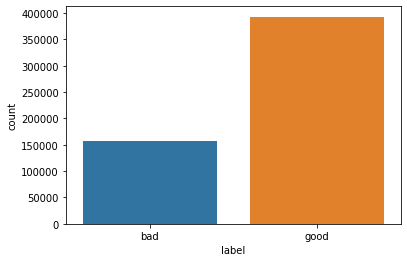

In [7]:
sns.countplot(x="label",data=df)

In [8]:
df['Y'] = df['label'].apply(lambda x: 0 if x == 'good' else 1)

# Feature Set 1: Properties of URL

In [9]:
def feature_creation(x):
    features = {}
    
    dom_ngram = {}
    subdom_ngram = {}

    dom = tldextract.extract(x).domain
    subdom = tldextract.extract(x).subdomain
    n  = 2
    for index in range(0, len(dom), n):
        dom_ngram[dom[index : index + n]] = 1
    features.update(dom_ngram)

    elements = [
    {"item": "domain", "data": tldextract.extract(x).domain},
    {"item": "subdomain", "data": tldextract.extract(x).subdomain},
    {"item": "suffix", "data": tldextract.extract(x).suffix},
    {"item": "path", "data": urlparse(x).path},
    {"item": "params", "data": urlparse(x).params},
    {"item": "query", "data": urlparse(x).query},
    {"item": "fragment", "data": urlparse(x).fragment}]
    
    for i in elements:
        features[f'len_{i["item"]}'] = len(i["data"])
        for sc in '!@#$%-_=~?+;':
            features[f'len_{sc}_in_{i["item"]}'] = i["data"].count(sc)
        if i["item"] in ['domain','path','subdomain']:
            features[f'len_digits_in_{i["item"]}'] = len(re.findall('[0-9]',x))
            features[f'len_alphas_in_{i["item"]}'] = len(re.findall('[a-z]',x.lower()))
    return features

In [16]:
df1 = df
y_elements = []
X_elements = []

for url, label in zip(df1['url'], df1['Y']):
    f = feature_creation(url)
    y_elements.append(label)
    X_elements.append(f)

In [17]:
len_domain = []
for i in X_elements:
    len_domain.append(i.get('len_domain'))
    
len_digits_in_domain =[]
for i in X_elements:
    len_digits_in_domain.append(i.get('len_digits_in_domain'))

len_alphas_in_path = []
for i in X_elements:
    len_alphas_in_path.append(i.get('len_alphas_in_path'))

len_digits_in_subdomain = []
for i in X_elements:
    len_digits_in_subdomain.append(i.get('len_digits_in_subdomain'))

len_alphas_in_subdomain =[]   
for i in X_elements:
    len_alphas_in_subdomain.append(i.get('len_alphas_in_subdomain'))

len_path = []
for i in X_elements:
    len_path.append(i.get('len_path'))
    
len_digits_in_path = []
for i in X_elements:
    len_digits_in_path.append(i.get('len_digits_in_path'))

len_alphas_in_path = []
for i in X_elements:
    len_alphas_in_path.append(i.get('len_alphas_in_path'))

len_suffix = []

In [18]:
pre_processor = DictVectorizer(sparse=True)
X = pre_processor.fit_transform(X_elements)
X = csr_matrix(X)
X = X.tocsr()
y = np.array(y_elements).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Set 2: Extraction using CountVectorizer

In [19]:
def url_process(url):
    url = re.sub('[^a-zA-Z\ \n]', '.', url.lower())
    url =  re.sub('\.{1,}', ' ', url)
    url = url.split(' ')
    
    stemmer = SnowballStemmer("english")
    url = [stemmer.stem(word) for word in url]
    url = ' '.join(url)
    return url

In [20]:
df2 = df
df2['url_clean'] = df2['url'].apply(url_process)

In [21]:
cv=CountVectorizer(ngram_range=(1, 2))

X_train, X_test, y_train, y_test = train_test_split(df2['url_clean'], df2['Y'], test_size=0.2, random_state=5555)

cv_fit = cv.fit(X_train)
X_train = cv_fit.transform(X_train)

X_test = cv_fit.transform(X_test)

In [22]:
df2.head()

,url,label,Y,url_clean
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,1,nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,1,www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,1,serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,1,mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,1,thewhiskeydreg com wp content theme widescreen...
